# Portfolio Optimisation - Notebook Two: Mean-Variance Optimisation

Aims of this notebook:
1. Load the data from Part 1
2. Build functions to calculate portfolio return and risk
3. Find the optimal portfolios (minimum variance, maximum Sharpe)
4. Plot the efficient frontier
5. Calculate risk metrics (VaR and CVaR)

This implements Modern Portfolio Theory (Markowitz) 

## 1. Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Set display options
pd.set_option('display.float_format', '{:.4f}'.format)
plt.style.use('seaborn-v0_8-whitegrid')

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [ ]:
# Returns data from notebook one
returns = pd.read_csv('../outputs/returns.csv', index_col=0, parse_dates=True)

print(f"Loaded {len(returns)} days of returns for {len(returns.columns)} stocks")
print(f"Stocks: {list(returns.columns)}")
returns.head()

Loaded 1257 days of returns for 6 stocks
Stocks: ['AAPL', 'JNJ', 'JPM', 'MSFT', 'PG', 'XOM']


,AAPL,JNJ,JPM,MSFT,PG,XOM
Date,,,,,,
2020-01-03,-0.0098,-0.0116,-0.0133,-0.0125,-0.0067,-0.0081
2020-01-06,0.0079,-0.0012,-0.0008,0.0026,0.0014,0.0076
2020-01-07,-0.0047,0.0061,-0.0171,-0.0092,-0.0062,-0.0082
2020-01-08,0.0160,-0.0001,0.0078,0.0158,0.0043,-0.0152
2020-01-09,0.0210,0.0030,0.0036,0.0124,0.0109,0.0076


## 2.Key Inputs

For mean-variance optimisation, we need:
- **Expected returns** (mean of historical returns, annualised)
- **Covariance matrix** (captures both volatility and correlations)

In [ ]:
# Annualised expected returns (252 trading days)
expected_returns = returns.mean() * 252

# Annualised covariance matrix
cov_matrix = returns.cov() * 252

# Number of assets
n_assets = len(returns.columns)
tickers = list(returns.columns)

print("Expected Annual Returns:")
print(expected_returns.round(4))
print("\nAnnualised Covariance Matrix:")
print(cov_matrix.round(4))

Expected Annual Returns:
AAPL   0.2477
JNJ    0.0259
JPM    0.1352
MSFT   0.2023
PG     0.0862
XOM    0.1322
dtype: float64

Annualised Covariance Matrix:
       AAPL    JNJ    JPM   MSFT     PG    XOM
AAPL 0.1002 0.0233 0.0426 0.0726 0.0284 0.0314
JNJ  0.0233 0.0385 0.0262 0.0226 0.0254 0.0203
JPM  0.0426 0.0262 0.1053 0.0420 0.0247 0.0639
MSFT 0.0726 0.0226 0.0420 0.0932 0.0288 0.0261
PG   0.0284 0.0254 0.0247 0.0288 0.0438 0.0165
XOM  0.0314 0.0203 0.0639 0.0261 0.0165 0.1183


## 3. Portfolio Return and Risk Functions

 Given a set of weights, we can calculate:
- **Portfolio return**: weighted average of individual returns
- **Portfolio volatility**: accounts for correlations via the covariance matrix

In R `function()` where as in Python `def`.

In [4]:
def portfolio_return(weights, expected_returns):
    """
    Calculate the expected return of a portfolio.
    
    Parameters:
    - weights: array of portfolio weights (must sum to 1)
    - expected_returns: expected return for each asset
    
    Returns:
    - Portfolio expected return (scalar)
    """
    return np.dot(weights, expected_returns)


def portfolio_volatility(weights, cov_matrix):
    """
    Calculate the volatility (standard deviation) of a portfolio.
    
    This uses the formula: sqrt(w' * Cov * w)
    where w is the weight vector and Cov is the covariance matrix.
    
    Parameters:
    - weights: array of portfolio weights
    - cov_matrix: covariance matrix of returns
    
    Returns:
    - Portfolio volatility (scalar)
    """
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))


def portfolio_sharpe(weights, expected_returns, cov_matrix, risk_free_rate=0.04):
    """
    Calculate the Sharpe ratio of a portfolio.
    
    Sharpe = (Portfolio Return - Risk Free Rate) / Portfolio Volatility
    
    Parameters:
    - weights: array of portfolio weights
    - expected_returns: expected return for each asset
    - cov_matrix: covariance matrix of returns
    - risk_free_rate: risk-free rate (default 4%)
    
    Returns:
    - Sharpe ratio (scalar)
    """
    ret = portfolio_return(weights, expected_returns)
    vol = portfolio_volatility(weights, cov_matrix)
    return (ret - risk_free_rate) / vol


print("Portfolio functions defined successfully!")

Portfolio functions defined successfully!


In [5]:
# Test with equal weights
equal_weights = np.array([1/n_assets] * n_assets)

print(f"Equal-weighted portfolio (1/{n_assets} each):")
print(f"  Expected Return: {portfolio_return(equal_weights, expected_returns):.2%}")
print(f"  Volatility:      {portfolio_volatility(equal_weights, cov_matrix):.2%}")
print(f"  Sharpe Ratio:    {portfolio_sharpe(equal_weights, expected_returns, cov_matrix):.3f}")

Equal-weighted portfolio (1/6 each):
  Expected Return: 13.83%
  Volatility:      20.33%
  Sharpe Ratio:    0.483


## 4. Generate Random Portfolios

Before optimising, let's visualise the "feasible region" by generating many random portfolios.
This shows all possible risk-return combinations we could achieve.

In [6]:
# Generate random portfolios
np.random.seed(42)  # For reproducibility
n_portfolios = 10000

# Store results
results = np.zeros((n_portfolios, 3))  # Return, Volatility, Sharpe
weights_record = []

for i in range(n_portfolios):
    # Generate random weights that sum to 1
    weights = np.random.random(n_assets)
    weights = weights / np.sum(weights)  # Normalise to sum to 1
    
    # Calculate metrics
    ret = portfolio_return(weights, expected_returns)
    vol = portfolio_volatility(weights, cov_matrix)
    sharpe = portfolio_sharpe(weights, expected_returns, cov_matrix)
    
    # Store
    results[i, :] = [ret, vol, sharpe]
    weights_record.append(weights)

# Convert to DataFrame for easier handling
portfolios_df = pd.DataFrame(results, columns=['Return', 'Volatility', 'Sharpe'])

print(f"Generated {n_portfolios} random portfolios")
print(f"Return range: {portfolios_df['Return'].min():.2%} to {portfolios_df['Return'].max():.2%}")
print(f"Volatility range: {portfolios_df['Volatility'].min():.2%} to {portfolios_df['Volatility'].max():.2%}")

Generated 10000 random portfolios
Return range: 6.83% to 20.70%
Volatility range: 17.58% to 27.58%


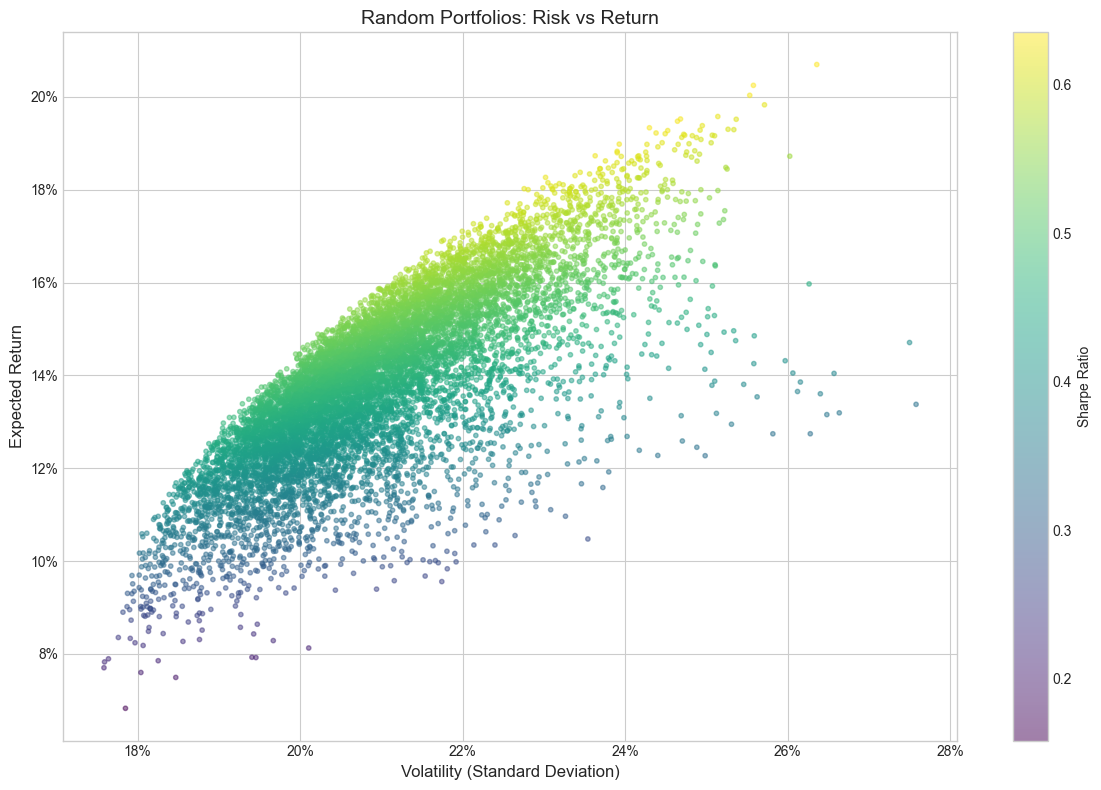

In [7]:
# Plot the random portfolios
fig, ax = plt.subplots(figsize=(12, 8))

# Scatter plot coloured by Sharpe ratio
scatter = ax.scatter(
    portfolios_df['Volatility'],
    portfolios_df['Return'],
    c=portfolios_df['Sharpe'],
    cmap='viridis',
    alpha=0.5,
    s=10
)

plt.colorbar(scatter, label='Sharpe Ratio')
ax.set_xlabel('Volatility (Standard Deviation)', fontsize=12)
ax.set_ylabel('Expected Return', fontsize=12)
ax.set_title('Random Portfolios: Risk vs Return', fontsize=14)

# Format axes as percentages
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))

plt.tight_layout()
plt.show()

## 5. Find Optimal Portfolios

Using scipy's optimiser to find:
1. **Minimum Variance Portfolio** - lowest risk regardless of return
2. **Maximum Sharpe Ratio Portfolio** - best risk-adjusted return

Similar to  `optim()` in R, but scipy uses a slightly different syntax.

In [8]:
# Constraints: weights must sum to 1
constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

# Bounds: each weight between 0 and 1 (no short selling)
bounds = tuple((0, 1) for _ in range(n_assets))

# Initial guess: equal weights
initial_weights = equal_weights

print("Optimisation constraints set:")
print("- Weights must sum to 1")
print("- No short selling (weights between 0 and 1)")

Optimisation constraints set:
- Weights must sum to 1
- No short selling (weights between 0 and 1)


In [9]:
# 1. MINIMUM VARIANCE PORTFOLIO
# Minimise volatility

def min_var_objective(weights):
    return portfolio_volatility(weights, cov_matrix)

min_var_result = minimize(
    min_var_objective,
    initial_weights,
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

min_var_weights = min_var_result.x
min_var_ret = portfolio_return(min_var_weights, expected_returns)
min_var_vol = portfolio_volatility(min_var_weights, cov_matrix)
min_var_sharpe = portfolio_sharpe(min_var_weights, expected_returns, cov_matrix)

print("MINIMUM VARIANCE PORTFOLIO")
print("=" * 40)
print(f"Expected Return: {min_var_ret:.2%}")
print(f"Volatility:      {min_var_vol:.2%}")
print(f"Sharpe Ratio:    {min_var_sharpe:.3f}")
print("\nWeights:")
for ticker, weight in zip(tickers, min_var_weights):
    print(f"  {ticker}: {weight:.2%}")

MINIMUM VARIANCE PORTFOLIO
Expected Return: 7.40%
Volatility:      17.53%
Sharpe Ratio:    0.194

Weights:
  AAPL: 2.04%
  JNJ: 47.00%
  JPM: 0.00%
  MSFT: 6.62%
  PG: 33.03%
  XOM: 11.31%


In [10]:
# 2. MAXIMUM SHARPE RATIO PORTFOLIO
# Minimise negative Sharpe (equivalent to maximising Sharpe)

def neg_sharpe_objective(weights):
    return -portfolio_sharpe(weights, expected_returns, cov_matrix)

max_sharpe_result = minimize(
    neg_sharpe_objective,
    initial_weights,
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

max_sharpe_weights = max_sharpe_result.x
max_sharpe_ret = portfolio_return(max_sharpe_weights, expected_returns)
max_sharpe_vol = portfolio_volatility(max_sharpe_weights, cov_matrix)
max_sharpe_sharpe = portfolio_sharpe(max_sharpe_weights, expected_returns, cov_matrix)

print("MAXIMUM SHARPE RATIO PORTFOLIO")
print("=" * 40)
print(f"Expected Return: {max_sharpe_ret:.2%}")
print(f"Volatility:      {max_sharpe_vol:.2%}")
print(f"Sharpe Ratio:    {max_sharpe_sharpe:.3f}")
print("\nWeights:")
for ticker, weight in zip(tickers, max_sharpe_weights):
    print(f"  {ticker}: {weight:.2%}")

MAXIMUM SHARPE RATIO PORTFOLIO
Expected Return: 23.02%
Volatility:      28.67%
Sharpe Ratio:    0.664

Weights:
  AAPL: 77.72%
  JNJ: 0.00%
  JPM: 0.00%
  MSFT: 11.81%
  PG: 0.00%
  XOM: 10.47%


## 6. Calculating Efficient Frontier

The efficient frontier shows the best possible return for each level of risk.
Found by minimising volatility for a range of target returns.

In [11]:
# Generate target returns from min variance return to max return
target_returns = np.linspace(min_var_ret, expected_returns.max(), 50)

efficient_volatilities = []
efficient_weights = []

for target in target_returns:
    # Add constraint: portfolio return must equal target
    constraints_with_return = [
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'eq', 'fun': lambda x, t=target: portfolio_return(x, expected_returns) - t}
    ]
    
    result = minimize(
        min_var_objective,
        initial_weights,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints_with_return
    )
    
    if result.success:
        efficient_volatilities.append(portfolio_volatility(result.x, cov_matrix))
        efficient_weights.append(result.x)
    else:
        efficient_volatilities.append(np.nan)
        efficient_weights.append(None)

print(f"Calculated {len([v for v in efficient_volatilities if not np.isnan(v)])} points on the efficient frontier")

Calculated 50 points on the efficient frontier


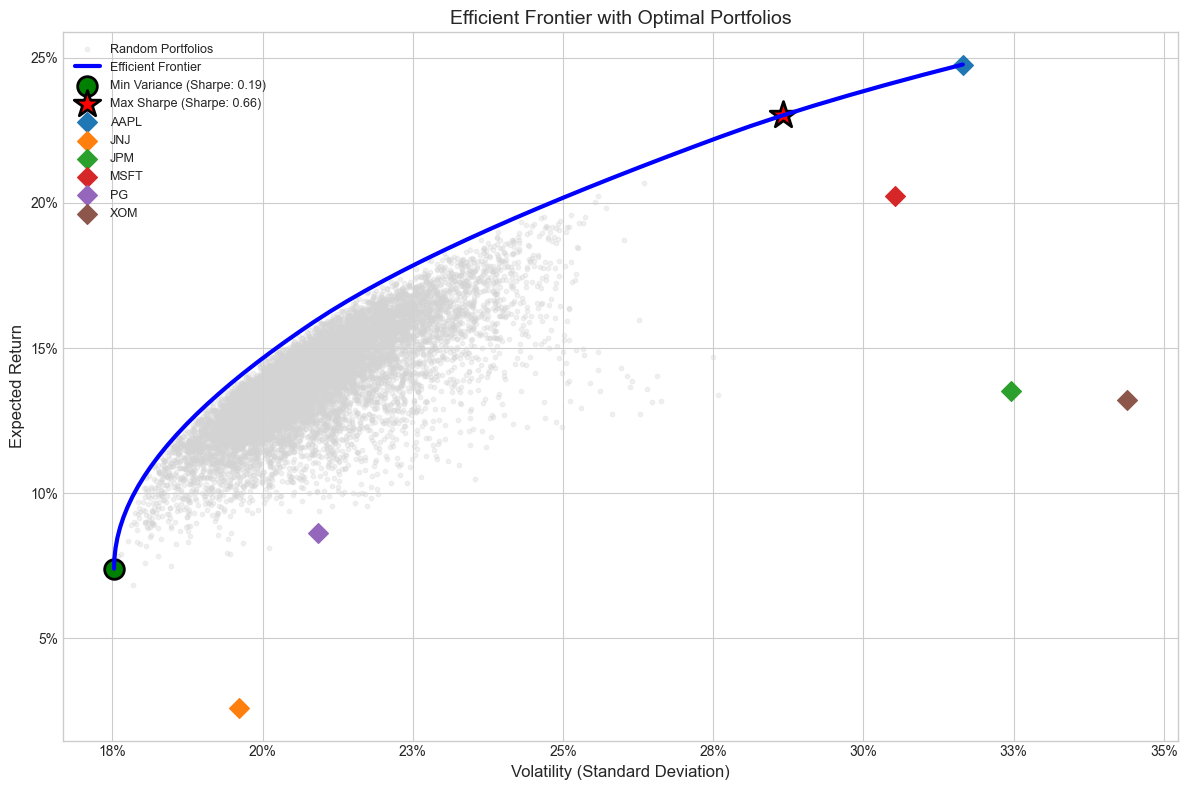


Plot saved to outputs/efficient_frontier.png


In [13]:
# Plot everything together
fig, ax = plt.subplots(figsize=(12, 8))

# Random portfolios
ax.scatter(
    portfolios_df['Volatility'],
    portfolios_df['Return'],
    c='lightgray',
    alpha=0.3,
    s=10,
    label='Random Portfolios'
)

# Efficient frontier
ax.plot(
    efficient_volatilities,
    target_returns,
    'b-',
    linewidth=3,
    label='Efficient Frontier'
)

# Minimum variance portfolio
ax.scatter(
    min_var_vol,
    min_var_ret,
    marker='o',
    color='green',
    s=200,
    edgecolors='black',
    linewidths=2,
    label=f'Min Variance (Sharpe: {min_var_sharpe:.2f})'
)

# Maximum Sharpe portfolio
ax.scatter(
    max_sharpe_vol,
    max_sharpe_ret,
    marker='*',
    color='red',
    s=400,
    edgecolors='black',
    linewidths=2,
    label=f'Max Sharpe (Sharpe: {max_sharpe_sharpe:.2f})'
)

# Individual stocks
for ticker in tickers:
    ax.scatter(
        np.sqrt(cov_matrix.loc[ticker, ticker]),
        expected_returns[ticker],
        marker='D',
        s=100,
        label=ticker
    )

ax.set_xlabel('Volatility (Standard Deviation)', fontsize=12)
ax.set_ylabel('Expected Return', fontsize=12)
ax.set_title('Efficient Frontier with Optimal Portfolios', fontsize=14)
ax.legend(loc='upper left', fontsize=9)

# Format axes as percentages
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))

plt.tight_layout()
plt.savefig('../outputs/efficient_frontier.png', dpi=150)
plt.show()

print("\nPlot saved to outputs/efficient_frontier.png")

## 7. Risk Metrics: VaR and CVaR

Now let's calculate Value at Risk (VaR) and Conditional VaR (CVaR/TVaR) for our optimal portfolio.

- **VaR**: The maximum loss at a given confidence level
- **CVaR**: The expected loss given that loss exceeds VaR (also called Expected Shortfall)

These are key risk metrics you'll recognise from your actuarial studies.

In [14]:
from scipy.stats import norm

def calculate_var(weights, expected_returns, cov_matrix, confidence=0.95, investment=1000000):
    """
    Calculate parametric VaR assuming normal distribution.
    
    Parameters:
    - weights: portfolio weights
    - confidence: confidence level (e.g., 0.95 for 95%)
    - investment: portfolio value in currency
    
    Returns:
    - VaR in currency terms (daily)
    """
    # Daily values (not annualised)
    port_return = portfolio_return(weights, expected_returns) / 252
    port_vol = portfolio_volatility(weights, cov_matrix) / np.sqrt(252)
    
    # VaR = -(mean - z * std) * investment
    z_score = norm.ppf(1 - confidence)
    var = -(port_return + z_score * port_vol) * investment
    
    return var


def calculate_cvar(weights, expected_returns, cov_matrix, confidence=0.95, investment=1000000):
    """
    Calculate parametric CVaR (Expected Shortfall) assuming normal distribution.
    
    CVaR is the expected loss given that the loss exceeds VaR.
    """
    # Daily values
    port_return = portfolio_return(weights, expected_returns) / 252
    port_vol = portfolio_volatility(weights, cov_matrix) / np.sqrt(252)
    
    # CVaR for normal distribution
    z_score = norm.ppf(1 - confidence)
    cvar = -(port_return - port_vol * norm.pdf(z_score) / (1 - confidence)) * investment
    
    return cvar


print("VaR and CVaR functions defined!")

VaR and CVaR functions defined!


In [15]:
# Calculate risk metrics for the Maximum Sharpe portfolio
investment = 1000000  # £1 million

print("RISK METRICS - Maximum Sharpe Portfolio")
print("=" * 50)
print(f"Investment: £{investment:,.0f}")
print()

for confidence in [0.95, 0.99]:
    var = calculate_var(max_sharpe_weights, expected_returns, cov_matrix, confidence, investment)
    cvar = calculate_cvar(max_sharpe_weights, expected_returns, cov_matrix, confidence, investment)
    
    print(f"{confidence:.0%} Confidence Level:")
    print(f"  Daily VaR:  £{var:,.0f}")
    print(f"  Daily CVaR: £{cvar:,.0f}")
    print()

RISK METRICS - Maximum Sharpe Portfolio
Investment: £1,000,000

95% Confidence Level:
  Daily VaR:  £28,792
  Daily CVaR: £36,339

99% Confidence Level:
  Daily VaR:  £41,100
  Daily CVaR: £47,220



In [16]:
# Historical VaR using actual portfolio returns
# This is a non-parametric approach - doesn't assume normality

# Calculate historical portfolio returns using max Sharpe weights
portfolio_returns = returns.dot(max_sharpe_weights)

def historical_var(returns, confidence=0.95, investment=1000000):
    """Calculate VaR from historical returns."""
    var_percentile = np.percentile(returns, (1 - confidence) * 100)
    return -var_percentile * investment

def historical_cvar(returns, confidence=0.95, investment=1000000):
    """Calculate CVaR from historical returns."""
    var_percentile = np.percentile(returns, (1 - confidence) * 100)
    cvar = returns[returns <= var_percentile].mean()
    return -cvar * investment

print("HISTORICAL VaR vs PARAMETRIC VaR")
print("=" * 50)
print(f"Investment: £{investment:,.0f}")
print()

for confidence in [0.95, 0.99]:
    param_var = calculate_var(max_sharpe_weights, expected_returns, cov_matrix, confidence, investment)
    hist_var = historical_var(portfolio_returns, confidence, investment)
    
    print(f"{confidence:.0%} Confidence Level:")
    print(f"  Parametric VaR:  £{param_var:,.0f}")
    print(f"  Historical VaR:  £{hist_var:,.0f}")
    print()

HISTORICAL VaR vs PARAMETRIC VaR
Investment: £1,000,000

95% Confidence Level:
  Parametric VaR:  £28,792
  Historical VaR:  £27,136

99% Confidence Level:
  Parametric VaR:  £41,100
  Historical VaR:  £47,348



## 8. Summary Table

Let's create a nice summary comparing our portfolios.

In [17]:
# Create summary DataFrame
summary = pd.DataFrame({
    'Equal Weight': [
        portfolio_return(equal_weights, expected_returns),
        portfolio_volatility(equal_weights, cov_matrix),
        portfolio_sharpe(equal_weights, expected_returns, cov_matrix),
        calculate_var(equal_weights, expected_returns, cov_matrix, 0.95, investment),
        calculate_cvar(equal_weights, expected_returns, cov_matrix, 0.95, investment)
    ],
    'Min Variance': [
        min_var_ret,
        min_var_vol,
        min_var_sharpe,
        calculate_var(min_var_weights, expected_returns, cov_matrix, 0.95, investment),
        calculate_cvar(min_var_weights, expected_returns, cov_matrix, 0.95, investment)
    ],
    'Max Sharpe': [
        max_sharpe_ret,
        max_sharpe_vol,
        max_sharpe_sharpe,
        calculate_var(max_sharpe_weights, expected_returns, cov_matrix, 0.95, investment),
        calculate_cvar(max_sharpe_weights, expected_returns, cov_matrix, 0.95, investment)
    ]
}, index=['Annual Return', 'Annual Volatility', 'Sharpe Ratio', '95% Daily VaR (£)', '95% Daily CVaR (£)'])

print("PORTFOLIO COMPARISON")
print("=" * 60)
summary

PORTFOLIO COMPARISON


,Equal Weight,Min Variance,Max Sharpe
Annual Return,0.1383,0.0740,0.2302
Annual Volatility,0.2033,0.1753,0.2867
Sharpe Ratio,0.4833,0.1943,0.6636
95% Daily VaR (£),20517.3743,17868.1072,28792.1914
95% Daily CVaR (£),25868.9938,22481.9756,36338.6763


In [18]:
# Create weights comparison
weights_df = pd.DataFrame({
    'Equal Weight': equal_weights,
    'Min Variance': min_var_weights,
    'Max Sharpe': max_sharpe_weights
}, index=tickers)

print("PORTFOLIO WEIGHTS")
print("=" * 60)
weights_df.round(4)

PORTFOLIO WEIGHTS


,Equal Weight,Min Variance,Max Sharpe
AAPL,0.1667,0.0204,0.7772
JNJ,0.1667,0.4700,0.0000
JPM,0.1667,0.0000,0.0000
MSFT,0.1667,0.0662,0.1181
PG,0.1667,0.3303,0.0000
XOM,0.1667,0.1131,0.1047


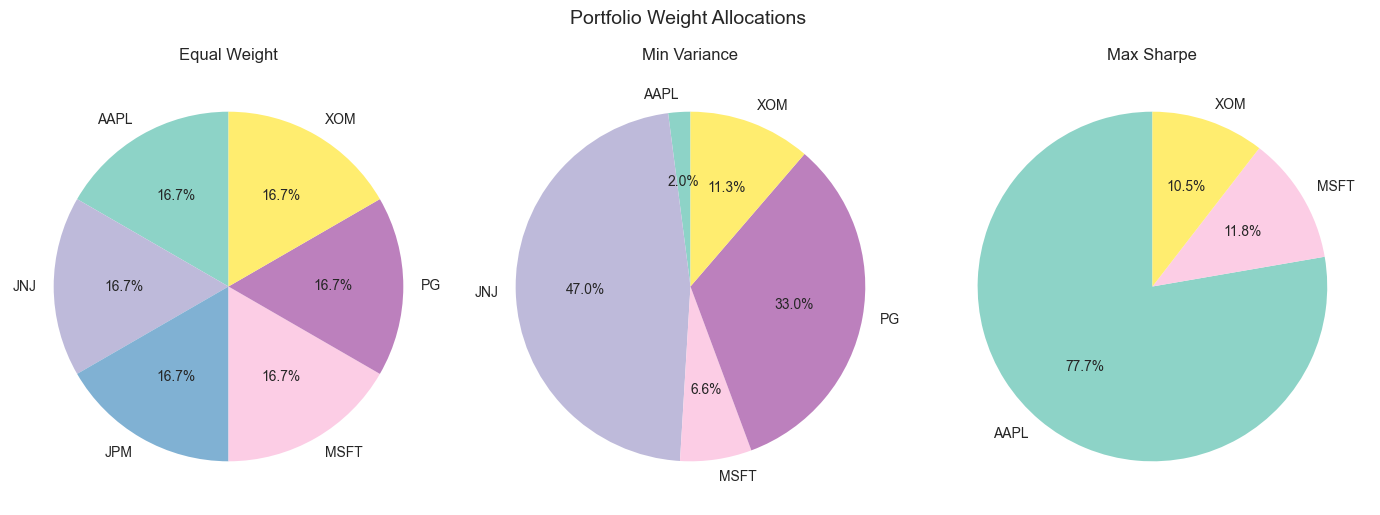


Plot saved to outputs/portfolio_weights.png


In [19]:
# Visualise weights
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

portfolios = ['Equal Weight', 'Min Variance', 'Max Sharpe']
weights_list = [equal_weights, min_var_weights, max_sharpe_weights]
colors = plt.cm.Set3(np.linspace(0, 1, n_assets))

for ax, name, weights in zip(axes, portfolios, weights_list):
    # Filter out very small weights for cleaner pie chart
    threshold = 0.01
    mask = weights >= threshold
    filtered_weights = weights[mask]
    filtered_tickers = [t for t, m in zip(tickers, mask) if m]
    filtered_colors = colors[mask]
    
    ax.pie(
        filtered_weights,
        labels=filtered_tickers,
        autopct='%1.1f%%',
        colors=filtered_colors,
        startangle=90
    )
    ax.set_title(name, fontsize=12)

plt.suptitle('Portfolio Weight Allocations', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('../outputs/portfolio_weights.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to outputs/portfolio_weights.png")

In [20]:
# Save results
summary.to_csv('../outputs/portfolio_summary.csv')
weights_df.to_csv('../outputs/optimal_weights.csv')

print("Results saved to outputs folder:")
print("- portfolio_summary.csv")
print("- optimal_weights.csv")
print("- efficient_frontier.png")
print("- portfolio_weights.png")

Results saved to outputs folder:
- portfolio_summary.csv
- optimal_weights.csv
- efficient_frontier.png
- portfolio_weights.png


## Summary

This notebook contains:

1. **Built portfolio functions** to calculate return, volatility, and Sharpe ratio
2. **Generated random portfolios** to visualise the feasible region
3. **Found optimal portfolios** using scipy optimisation:
   - Minimum Variance Portfolio (lowest risk)
   - Maximum Sharpe Ratio Portfolio (best risk-adjusted return)
4. **Calculated the Efficient Frontier** - the set of optimal portfolios
5. **Computed risk metrics**: VaR and CVaR (both parametric and historical)
6. **Created visualisations** for the efficient frontier and portfolio allocations

**Key Concepts Demonstrated:**
- Modern Portfolio Theory (Markowitz mean-variance optimisation)
- Constrained optimisation with scipy
- Risk metrics used in finance and insurance (VaR, CVaR)
- Data visualisation for financial analysis

